# Семинар 8: Metric learning for face recognition

<img src="https://insightface.ai/assets/img/github/facerecognitionfromvideo.PNG" alt="drawing" width="800"/>

## Содержание семинара
На этом семинаре мы
1. Поставим задачу распознавания лиц.
2. Опишем в общем виде pipeline для решения задачи распознавания.
3. Разберём нейросетевую модель [ArcFace](https://arxiv.org/abs/1801.07698), используемую для получения грубоких представлений.
4. Обучим ArcFace модель на небольшом наборе данных.
5. Применим полученные знания для решения задачи распознавания лиц на наборе данных [EasyPortrait](https://github.com/ai-forever/easyportrait).

## 1. Постановка задачи распознавания лиц

Принято выделять три стандартные постановки задачи распознавания лиц: верификация, открытая и закрытая идентификация (смотри [Handbook of Face Recognition](https://link.springer.com/book/10.1007/978-0-85729-932-1)).
Верификация и закрытая идентификация являются частными случаями задачи отрытой идентификации. 

На нашем занятии мы рассмотрим задачу верификации лиц.

## 4. Обучение ArcFace на небольшом наборе данных

### Подготовка данных

In [1]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import mxnet as mx
import numbers
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import os
from pathlib import Path

In [2]:

class MXFaceDataset(Dataset):
    def __init__(self, root_dir, test=False):
        """
        ArcFace loader
        https://github.com/deepinsight/insightface/blob/master/recognition/arcface_torch/dataset.py
        """
        super(MXFaceDataset, self).__init__()

        self.test = test
        if self.test:
            self.transform = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ]
            )
        else:

            self.transform = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ]
            )
        self.root_dir = root_dir
        path_imgrec = os.path.join(root_dir, "train.rec")
        path_imgidx = os.path.join(root_dir, "train.idx")
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, "r")
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys))
        labels_path = Path(root_dir) / 'labels.npy'
        if labels_path.is_file:
            self.labels = np.load(labels_path)
        else:
            labels = []
            for i in tqdm(range(len(self.imgidx))):
                idx = self.imgidx[i]
                s = self.imgrec.read_idx(idx)
                header, img = mx.recordio.unpack(s)
                label = header.label
                labels.append(int(label))
            labels = np.array(labels)
            np.save(labels_path, labels)
        unique_labels, unique_counts =  np.unique(self.labels, return_counts=True)
        top_8_ids = np.argsort(unique_counts)[::-1][:8]
        self.top_8_labels = unique_labels[top_8_ids]

        self.label_map = dict(zip(self.top_8_labels.tolist(), np.arange(len(self.top_8_labels))))

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = self.label_map[int(label)]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        if self.test:
            return sample
        else:
            return sample, label

    def __len__(self):
        return len(self.imgidx)

In [3]:
ms1m_dataset = MXFaceDataset('data/ms1m/')
eight_people_ids =  np.where(np.isin(ms1m_dataset.labels, ms1m_dataset.top_8_labels))[0]
eight_people_set = torch.utils.data.Subset(ms1m_dataset, eight_people_ids)

### Задание модели

In [4]:
from iresnet import iresnet50_normalized


class ArcFaceLoss(torch.nn.Module):
    def __init__(self, s=64.0, m=0.5):
        super(ArcFace, self).__init__()
        self.s = s
        self.m = m

    def forward(self, logits, labels):
        cosine, gty = 1, 2#kwargs["cosine"], kwargs["label"]
        index = torch.where(gty != -1)[0]
        m_hot = torch.zeros(index.size()[0], cosine.size()[1], device=cosine.device)
        m_hot.scatter_(1, gty[index, None], self.m)
        cosine.acos_()
        cosine[index] += m_hot
        cosine.cos_().mul_(self.s)
        return cosine

class ArcFace(pl.LightningModule):
    def __init__(
        self,
        backbone: torch.nn.Module,
        loss: torch.nn.Module,
    ):
        super().__init__()
        self.backbone = backbone
        self.loss = loss
        self.softmax_weights = torch.nn.Parameter(torch.zeros(2, 8), requires_grad=True)

    def forward(self, x):
        backbone_outputs = self.backbone(x)
        features = backbone_outputs["feature"]
        logits = torch.matmul(features, F.normalize(self.softmax_weights, dim=0))
        return features, logits

    def training_step(self, batch):
        images, labels = batch
        features, logits = self(images)
        loss = self.loss(logits, labels)
        self.log("train_loss", loss.item(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        params = list(self.backbone.parameters()) + [self.softmax_weights]
        optimizer = torch.optim.AdamW(params, lr=1e-3, weight_decay=5e-3)
        return {
            "optimizer": optimizer,
            # "lr_scheduler": {
            #     "scheduler": getattr(
            #         importlib.import_module("torch.optim.lr_scheduler"),
            #         self.scheduler_params["scheduler"],
            #     )(optimizer, **self.scheduler_params["params"]),
            #     "interval": "step",
            #},
        }

    def predict_step(self, batch, batch_idx):
        images_batch = batch
        
        images_batch = images_batch.permute(0, 3, 1, 2)

        return self(images_batch)
    
backbone_model = iresnet50_normalized(num_features=2)
softmax_loss = torch.nn.CrossEntropyLoss()
arcface_model = ArcFace(backbone_model, softmax_loss)

In [5]:
batch_size = 128
num_workers = 10

In [6]:
from pytorch_lightning import Trainer
import pytorch_lightning as pl
trainer = Trainer(max_epochs=10, default_root_dir='outputs/softmax_train')
train_dataloader = DataLoader(
            eight_people_set,
            batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=num_workers,
        )
trainer.fit(arcface_model, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name

Epoch 7:   0%|          | 0/17 [00:00<?, ?it/s, v_num=1, train_loss=1.410]         

### Вычисление представлений

In [9]:
backbone_model = iresnet50_normalized(num_features=2)
softmax_loss = torch.nn.CrossEntropyLoss()
checkpoint_path = "outputs/softmax_train/lightning_logs/version_0/checkpoints/epoch=2-step=51.ckpt"
softmax_model = ArcFace.load_from_checkpoint(backbone=backbone_model, loss=softmax_loss, checkpoint_path=checkpoint_path)


In [10]:
def predict_features(model):
    test_dataloader = DataLoader(
                eight_people_set,
                batch_size,
                shuffle=False,
                drop_last=False,
                num_workers=num_workers,
            )
    cuda = torch.device('cuda')
    model.to(cuda)
    # disable randomness, dropout, etc...
    model.eval()
    predicted_features = []
    image_labels = []
    for batch in tqdm(test_dataloader):
        images, labels = batch
        images = images.to(cuda)
        features, _ = model(images)
        features = features.detach().cpu().numpy()
        labels = labels.numpy()
        predicted_features.append(features)
        image_labels.append(labels)
    predicted_features = np.concatenate(predicted_features)
    image_labels = np.concatenate(image_labels)
    return predicted_features, image_labels

In [11]:
predicted_features, image_labels = predict_features(softmax_model)

100%|██████████| 35/35 [00:23<00:00,  1.46it/s]


In [34]:
softmax_weights = softmax_model.softmax_weights.detach().cpu()

In [36]:
softmax_weights = F.normalize(softmax_weights, dim=0).numpy()

In [53]:
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)[:8]

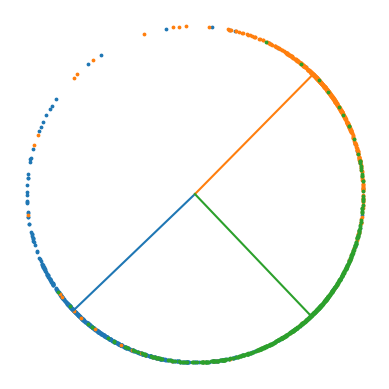

In [61]:
import matplotlib.pyplot as plt
max_classes = 3
for i, (weight, color) in enumerate(zip(softmax_weights.T, colors)):
    points = predicted_features[image_labels==i]
    x, y = [0, weight[0]], [0, weight[1]]
    plt.plot(x, y, marker = '',c = color)
    plt.scatter(points[:,0], points[:,1], color=color, s=3)
    if i == (max_classes - 1):
        break
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

In [55]:
color

'tab:gray'

In [47]:
softmax_weights.T

array([[-0.7221821 , -0.691703  ],
       [ 0.70223534,  0.7119449 ],
       [ 0.68961954, -0.7241718 ],
       [ 0.6691575 , -0.7431206 ],
       [-0.7181274 ,  0.6959116 ],
       [-0.7263381 , -0.6873376 ],
       [ 0.69119895,  0.72266454],
       [ 0.70368135,  0.71051574]], dtype=float32)

In [41]:
weight

array([-0.7221821, -0.691703 ], dtype=float32)

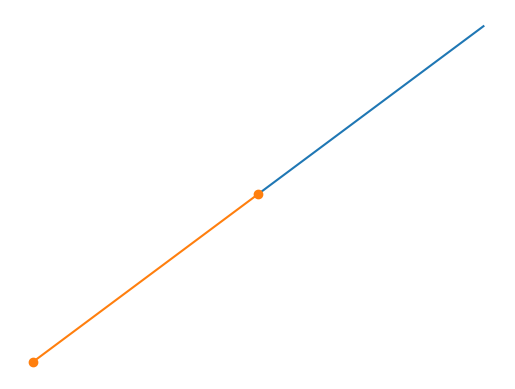

In [39]:


x2, y2 = [0, -5], [0, -5]



## 5. Решение задачи верификации на наборе данных EasyPortrait

### Подготовка данных

In [153]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt


data_dir = Path('data/easy_portrait')
data_dir.mkdir(exist_ok=True)
images_dir = data_dir / 'images'
images_dir.mkdir(exist_ok=True)

In [2]:
#!wget https://n-ws-620xz-pd11.s3pd11.sbercloud.ru/b-ws-620xz-pd11-jux/easyportrait/images.zip -O data/images.zi
#!unzip -q data/images.zip -d data/easy_portrait/images

In [3]:
#!wget https://n-ws-620xz-pd11.s3pd11.sbercloud.ru/b-ws-620xz-pd11-jux/easyportrait/annotations.zip -O data/annotations.zip

#!unzip data/annotations.zip -d data/easy_portrait
#!unzip data/easy_portrait/meta.zip -d data/easy_portrait

#### Вычисление глубоких представлений

С помощью детектора лиц [SCRFD](https://arxiv.org/pdf/2105.04714.pdf) и [ArcFace](https://arxiv.org/abs/1801.07698) модели на базе [ResNet-50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html), обученной на наборе данных [WebFace600K](https://www.face-benchmark.org/download.html), получим представления лиц набора EasyPortrait.

In [4]:
import torch
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

# app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'], root='./data/insightface')
# app.prepare(ctx_id=0, det_size=(640, 640))
# img = ins_get_image('t1')
# faces = app.get(img)
# rimg = app.draw_on(img, faces)
# cv2.imwrite("data/t1_output.jpg", rimg)

In [14]:

# face_meta = pd.read_csv('/app/spring_2023/s8_face_recognition/data/easy_portrait/meta.csv')

# image_paths = []
# user_ids = []
# embeddings = []
# for i, record in tqdm(face_meta.iterrows(), total=20000):
#     if record['test'] is True:
#         subset = 'test'
#     if record['train'] is True:
#         subset = 'train'
#     if record['valid'] is True:
#         subset = 'val'
#     image_path = str(images_dir / subset / (record['attachment_id'] + '.jpg'))
#     image = cv2.imread(image_path)
#     faces = app.get(image)

#     if len(faces) == 1:
#         image_paths.append(image_path)
#         user_ids.append(record['user_id'])
#         embeddings.append(faces[0].normed_embedding[np.newaxis,:])
# embeddings = np.concatenate(embeddings)

  0%|          | 0/20000 [00:00<?, ?it/s]/home/erlygin/miniconda/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
100%|██████████| 20000/20000 [27:52<00:00, 11.95it/s]


In [6]:
# save embeddings and meta data
embeddings_dir = Path('data/embeddings')
# embeddings_dir.mkdir(exist_ok=True)
# np.save(embeddings_dir / 'image_paths.npy', np.array(image_paths))
# np.save(embeddings_dir / 'user_ids.npy', np.array(user_ids))
# np.save(embeddings_dir / 'embeddings.npy', embeddings)

#### Определение протокола верификации

Множество изображений для каждого человека разобъем на равных случайных шаблона, которые затем будем использовать для подсчёта точности верификации. 

Мы хотим составить список пар изображение, среди которых будут пары изображений одного и того же человека и изображения разных людей.  
Для составления негативных пар возьмём из каждого шаблона по одному изображению и выпишем множество всевозможных пар шаблонов.  
Для составления позитивных пар возьмём всевозможные пары в шаблоне для каждого человека.

In [7]:
user_ids = np.load(embeddings_dir / 'user_ids.npy')
embeddings = np.load(embeddings_dir / 'embeddings.npy')
image_paths = np.load(embeddings_dir / 'image_paths.npy')

face_meta = pd.DataFrame({'user_id': user_ids, 'image_path': image_paths, 'embedding_id': np.arange(len(embeddings))})

In [19]:
len(image_paths)

19682

In [79]:
# split images to templates
seed = 0
rs = np.random.default_rng(seed)

template_ids = []
template_user_ids = []
template_emb_ids = []
for i, (user_id, user_data) in enumerate(face_meta.groupby('user_id')):
    if user_data.user_id.values[0] == 'nan':
        continue
    num_images = len(user_data)
    if num_images == 1:
        # single image template
        template_ids += [2 * i]
        template_user_ids += [user_id]
        template_emb_ids += user_data['embedding_id'].values.tolist()
    else:
        # split template in two random halves
        random_order_ids = rs.permutation(num_images)
        first_template_data = user_data.iloc[random_order_ids[:num_images // 2]]
        second_template_data = user_data.iloc[random_order_ids[num_images // 2:]]
        template_ids += [2 * i] * len(first_template_data)
        template_ids += [2 * i + 1] * len(second_template_data)

        template_user_ids += first_template_data['user_id'].values.tolist()
        template_user_ids += second_template_data['user_id'].values.tolist()

        template_emb_ids += first_template_data['embedding_id'].values.tolist()
        template_emb_ids += second_template_data['embedding_id'].values.tolist()
templates = pd.DataFrame({'template_id': template_ids, 'user_id': template_user_ids, 'embedding_id': template_emb_ids})
templates.to_csv(embeddings_dir / 'templates.csv', index=False)

In [80]:
templates.head(10)

,template_id,user_id,embedding_id
0,0,000846d038cc6289acf99f0739820896,3089
1,1,000846d038cc6289acf99f0739820896,5996
2,2,00099c87ff8a19643dbd31bf93bb1436,15643
3,4,00144dc200f186ef726669e9cd1332b7,5514
4,6,00147a746157ebb329c05140a2bf2517,7738
5,8,00199404ae6d1063db15036c13c11220,7966
6,10,00302ddd5c724605f069844551d556ee,16190
7,12,0035661ffcd9e638a7be40a26bf12f32,14016
8,14,0037b7b1bf9e84f38c0808fb7bcdbcf2,16624
9,16,0041ec866777f12c384b64d8cd636277,4299


In [81]:
# list positive and negative pairs

templates = pd.read_csv(embeddings_dir / 'templates.csv')

In [106]:
first_template_positive = []
second_template_positive = []


# add positive pairs
for i, (user_id, user_data) in enumerate(templates.groupby('user_id')):
    unique_templates = user_data['template_id'].unique()
    if len(unique_templates) == 1:
        continue
    else:
        assert len(unique_templates) == 2
        first_template_positive += [unique_templates[0]]
        second_template_positive += [unique_templates[1]]

# add negative pairs
# from each subject first template is taken to match with others
user_to_template_id = {}
for i, (user_id, user_data) in enumerate(templates.groupby('user_id')):
    unique_templates = user_data['template_id'].unique()
    user_to_template_id[user_id] = unique_templates[0]
unique_user_ids = templates['user_id'].unique()

first_template_negative = []
second_template_negative = []

for first_id in tqdm(unique_user_ids):
    for second_id in unique_user_ids:
        if second_id == first_id:
            continue
        first_template_negative.append(user_to_template_id[first_id])
        second_template_negative.append(user_to_template_id[second_id])

100%|██████████| 8262/8262 [00:24<00:00, 344.15it/s]


In [109]:
first_template_negative = np.array(first_template_negative)
second_template_negative = np.array(second_template_negative)
first_template_positive = np.array(first_template_positive)
second_template_positive = np.array(second_template_positive)

In [196]:
negative_pair_size = 5000000
seed = 0
rs = np.random.default_rng(seed)
random_order_ids = rs.permutation(len(first_template_negative))
negative_ids = random_order_ids[:negative_pair_size]
first_template = np.concatenate([first_template_positive, first_template_negative[negative_ids]])
second_template = np.concatenate([second_template_positive, second_template_negative[negative_ids]])
is_positive = [True] * len(first_template_positive) + [False] * len(negative_ids)

pairs = pd.DataFrame({'first_template': first_template, 'second_template': second_template, 'is_positive': is_positive})
pairs.to_csv(embeddings_dir / 'pairs.csv', index=False)

### Подсчёт метрик точности верификации

In [197]:
pairs = pd.read_csv(embeddings_dir / 'pairs.csv')
templates = pd.read_csv(embeddings_dir / 'templates.csv')
embeddings = np.load(embeddings_dir / 'embeddings.npy')

In [198]:
templates

,template_id,user_id,embedding_id
0,0,000846d038cc6289acf99f0739820896,3089
1,1,000846d038cc6289acf99f0739820896,5996
2,2,00099c87ff8a19643dbd31bf93bb1436,15643
3,4,00144dc200f186ef726669e9cd1332b7,5514
4,6,00147a746157ebb329c05140a2bf2517,7738
...,...,...,...
19551,16515,ffca0a846eea5f01deeab72e9f407428,15568
19552,16516,ffce02f942d36b6338290d0580dcb779,10100
19553,16518,ffddd372a507d5c234343da1af4a23c9,16191
19554,16520,fff39c130e0a6cbad6f96964f1756b73,16946


In [214]:
# pool template embs
template_pooled_embs = []
for i, (template_id, template_data) in enumerate(templates.groupby('template_id')):
    emb_ids = template_data['embedding_id'].values
    template_embeddinds = embeddings[emb_ids]
    mean_emb = np.mean(template_embeddinds, axis=0, keepdims=True)
    template_pooled_embs.append(mean_emb / np.linalg.norm(mean_emb))
template_pooled_embs = np.concatenate(template_pooled_embs)

In [215]:
unique_templates = templates['template_id'].unique()
template2id = np.zeros(max(unique_templates) + 1, dtype=int)
template2id[unique_templates] = np.arange(len(unique_templates))

def distance_function(X_1, X_2):
    return np.sum(X_1 * X_2, axis=1)

p1 = pairs['first_template'].values
p2 = pairs['second_template'].values

batch_size = 10000
steps = int(np.ceil(len(p1) / batch_size))
scores = []
for id in tqdm(range(steps), "Verification"):
    
    feat1 = template_pooled_embs[
                template2id[p1[id * batch_size : (id + 1) * batch_size]]
            ]
    feat2 = template_pooled_embs[
                template2id[p2[id * batch_size : (id + 1) * batch_size]]
    ]
    scores.extend(distance_function(feat1, feat2))
scores = np.array(scores)

Verification: 100%|██████████| 501/501 [00:08<00:00, 55.71it/s]


In [216]:
def draw_score_distr_plot(
    scores_distr, positive_pair_name, negative_pair_name
):
    sns.set_theme()
    plt.figure(figsize=(12, 8))
    sns.distplot(
        scores_distr[positive_pair_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=positive_pair_name,
    )
    sns.distplot(
        scores_distr[negative_pair_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=negative_pair_name,
    )

    plt.xlabel(f"Косинусная схожесть")

    plt.legend()

/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


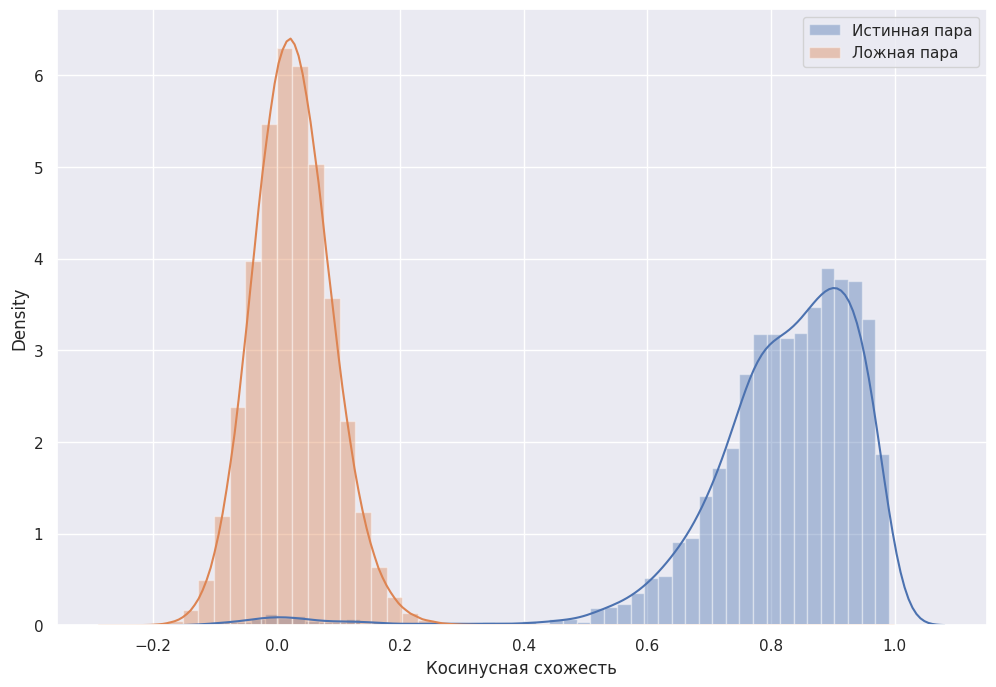

In [217]:
is_positive = pairs['is_positive'].values

true_match_scores = scores[is_positive]
wrong_match_scores = scores[is_positive == 0]
scores_distr = {
        "Истинная пара": true_match_scores,
        "Ложная пара": wrong_match_scores,
    }
draw_score_distr_plot(
    scores_distr=scores_distr,
    positive_pair_name="Истинная пара",
    negative_pair_name="Ложная пара",
)

### TAR@FAR кривая

In [218]:
fars = [10 ** ii for ii in np.arange(-6, 0, 4 / 100)] + [1]
threshes, recalls = [], []
wrong_match_scores_sorted = np.sort(wrong_match_scores)[::-1]
for far in fars:
    thresh = wrong_match_scores_sorted[max(int((wrong_match_scores_sorted.shape[0]) * far) - 1, 0)]
    recall = (
            np.sum(true_match_scores > thresh)
            / true_match_scores.shape[0]
        )
    threshes.append(thresh)
    recalls.append(recall)

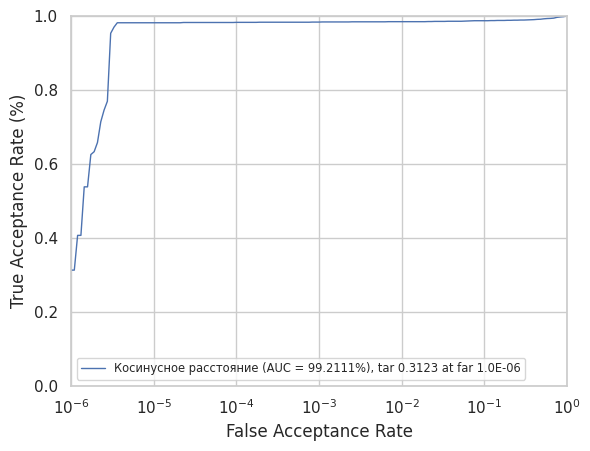

In [219]:
from sklearn.metrics import auc
sns.set_style("whitegrid")
fig = plt.figure()

auc_value = auc(fars, recalls)
label = "%s (AUC = %0.4f%%), tar %0.4f at far %.1E" % (
    'Косинусное расстояние',
    auc_value * 100,
    recalls[0],
    fars[0],
)
plt.plot(fars, recalls, lw=1, label=label)

plt.xlabel("False Acceptance Rate")
plt.xlim([fars[0], 1])
plt.xscale("log")
plt.ylabel("True Acceptance Rate (%)")
plt.ylim([0, 1])

#plt.grid(linestyle="--", linewidth=1)
plt.legend(fontsize="x-small")
#plt.tight_layout()
plt.show()